In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
 
# load dataset
dataset = read_csv('/Users/manali/Downloads/train_data.csv')
dataset= dataset.drop(columns=["ID"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/manali/Downloads/test_data.csv')
validation= validation.drop(columns=["ID"])
values_validation = validation.values


   time_since_last_recording   latency      cost  reliability  \
0                   0.000000  0.433568  0.114583            1   
1                   0.911953  0.014534  0.354167            1   
2                   0.490876  0.030913  0.364583            1   
3                   0.410584  0.035595  0.354167            1   
4                   0.630474  0.067912  0.343750            1   

   time_since_last_ping  last_ping  
0              0.000000          0  
1              0.103199          1  
2              0.658927          1  
3              0.273478          1  
4              0.360681          1  


In [4]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,10,11]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,10,11]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var2(t)  \
1        0.0   0.433568   0.114583        1.0        0.0        0.0  0.014534   

    var3(t)  var4(t)  
1  0.354167      1.0  


In [5]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(149, 1, 6) (149, 3) (24, 1, 6) (24, 3)


Epoch 1/20
149/149 [==============================] - 0s 596us/step - loss: 0.3603
Epoch 2/20
149/149 [==============================] - 0s 38us/step - loss: 0.2557
Epoch 3/20
149/149 [==============================] - 0s 60us/step - loss: 0.1701
Epoch 4/20
149/149 [==============================] - 0s 38us/step - loss: 0.1085
Epoch 5/20
149/149 [==============================] - 0s 41us/step - loss: 0.0667
Epoch 6/20
149/149 [==============================] - 0s 54us/step - loss: 0.0404
Epoch 7/20
149/149 [==============================] - 0s 69us/step - loss: 0.0270
Epoch 8/20
149/149 [==============================] - 0s 54us/step - loss: 0.0233
Epoch 9/20
149/149 [==============================] - 0s 68us/step - loss: 0.0238
Epoch 10/20
149/149 [==============================] - 0s 57us/step - loss: 0.0243
Epoch 11/20
149/149 [==============================] - 0s 55us/step - loss: 0.0232
Epoch 12/20
149/149 [==============================] - 0s 56us/step - loss: 0.0216
Epoch 13/20


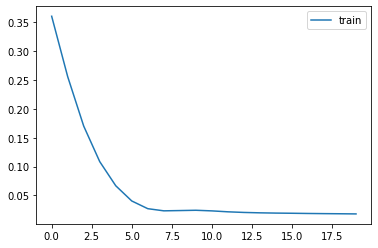

In [6]:
## Run this cell for MLP , else Run the next cell for LSTM

# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
X = train_X.reshape((train_X.shape[0], n_input))

# define MLP model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')
history= model.fit(X, train_y, epochs=20, verbose=1)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [7]:
### Doing the same process for testing dataset

test_dataset = read_csv('/Users/manali/Downloads/validate_data.csv')
test_dataset= test_dataset.drop(columns=["ID"])
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,10,11]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))


In [8]:
## Feeding the test dataset for predictions
import pandas as pd

## For MLP use below line only
yhat = model.predict(testset_X)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[ 0.1127829   0.39132103  1.035585  ]
 [ 0.12084904  0.40963507  1.044046  ]
 [ 0.06241288  0.35602248  0.9844213 ]
 [ 0.14042145  0.39348596  1.0094784 ]
 [ 0.0533183   0.37335783  0.99034125]
 [ 0.02634906  0.3695126   0.9918943 ]
 [ 0.08519518  0.37885448  1.037864  ]
 [ 0.05710079  0.36977082  0.9088233 ]
 [ 0.09000395  0.35164765  0.93361795]
 [-0.03364644  0.38971347  1.0706955 ]
 [ 0.18664253  0.26518893  1.0951693 ]
 [ 0.08967689  0.37364873  0.97275794]
 [ 0.09428737  0.43293437  1.2033539 ]
 [ 0.06420603  0.3397705   0.8274444 ]
 [ 0.12056698  0.3929829   1.0520446 ]
 [ 0.08086844  0.11168385  1.0570487 ]
 [ 0.21546566  0.30840817  1.1423067 ]
 [ 0.14966325  0.2827272   0.94857293]
 [ 0.16569054  0.3209832   1.047455  ]
 [ 0.1064924   0.38587245  0.98152965]
 [ 0.08098811  0.36359227  0.9380129 ]
 [ 0.0804691   0.35307872  1.00422   ]
 [ 0.05371269  0.40436217  1.094324  ]
 [ 0.11984849  0.32505876  0.9730565 ]]


In [9]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [10]:
import numpy as np
result.head(10)
result.to_csv('/Users/manali/JupyterProjects/predictions_MLP.csv', sep=',', index=0)

In [11]:
print(testset_y)

[[4.57773760e-02 2.94117647e-01 1.00000000e+00]
 [1.53205344e-01 5.29411765e-01 1.00000000e+00]
 [4.33488200e-02 0.00000000e+00 1.00000000e+00]
 [4.79643620e-02 4.90196078e-01 1.00000000e+00]
 [8.60406740e-02 7.64705882e-01 1.00000000e+00]
 [6.43475000e-04 3.92156863e-01 1.00000000e+00]
 [0.00000000e+00 3.33333333e-01 1.00000000e+00]
 [1.35487030e-01 3.92156863e-01 1.00000000e+00]
 [4.91627560e-02 1.00000000e+00 1.00000000e+00]
 [8.60693975e-01 5.09803922e-01 1.00000000e+00]
 [9.03644290e-02 4.31372549e-01 1.00000000e+00]
 [3.79898900e-03 4.31372549e-01 1.00000000e+00]
 [8.74877300e-02 3.13725490e-01 1.00000000e+00]
 [1.23398101e-01 3.72549020e-01 1.00000000e+00]
 [1.00000000e+00 2.15686275e-01 1.00000000e+00]
 [6.05305612e-01 3.13725490e-01 1.00000000e+00]
 [5.30306584e-01 3.33333333e-01 1.00000000e+00]
 [4.73442016e-01 4.31372549e-01 1.00000000e+00]
 [6.77231050e-02 2.74509804e-01 1.00000000e+00]
 [8.46984340e-02 3.72549020e-01 1.00000000e+00]
 [3.25987880e-02 4.11764706e-01 1.000000

In [12]:
## Finding the root mean squared error of the model

rmse = sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.215
